# Getting Started With Dataset

In this notebook, we'll acquaint with dataset library. For this purpose, let's write simple regression models.

You can see the implementation of MyBatch class in [mybatch.py](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/mybatch.py),
data generation function in [data_generator.py](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/data_generator.py), and models in [models.py](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/models.py).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from mybatch import MyBatch
from models import Regressions
from data_generator import generate_linear_data, \
                           generate_logistic_data, \
                           generate_poisson_data
from dataset import Dataset, DatasetIndex, V, F, B

## First, we consider linear regression that allows solving tasks where answers are continuous variables.
For this we generate data from uniform or normal distributions, multiply it by normally distributed weights and add normally distributed noise and then try to predict it. 

In this case, <i>linear_x and linear_y</i> are two numpy arrays. Data is a matrix with __size__ rows and 13 cols. Prediction value is numpy array with len equal __size__.

In [2]:
size = 1000
linear_x, linear_y = generate_linear_data(size=size)

Now it's time to create Dataset (the instance of Dataset class) with our class named __MyBatch__ and split it into train/test. Dataset is needed to create batches in future, but now the Dataset is empty until we load the data into it. First of all, we create __Index__ for our Dataset. The __Index__ holds the sequence of data items' indices. This mechanism is needed to uniquely address each data item. You can read more about [using](https://analysiscenter.github.io/dataset/intro/intro.html) Dataset, Dataset [itself](https://analysiscenter.github.io/dataset/intro/dataset.html), and [Index](https://analysiscenter.github.io/dataset/intro/index.html).

In [3]:
ind = DatasetIndex(np.arange(size))
linear_dset = Dataset(ind, batch_class=MyBatch)
linear_dset.cv_split()

After creating a Dataset we can load data into it with [pipeline](https://analysiscenter.github.io/dataset/intro/pipeline.html) which allows you to use and perform functions from your [batch class](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/mybatch.py). As for example __load__ from [mybatch](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/mybatch.py) in the cell below.

In [4]:
pipeline = (linear_dset.train.p
                .load((linear_x, linear_y)))

The pipeline shows only loading data and doesn't train linear regression, therefore this is not enough for us. 
But before talking about "How to train linear regression?" let's talk about "What will we generally train?".

All possible algorithms that can be trained in Dataset are named models. In our case, they are based on tensorflow. Hence, first of all, we need to create a model with linear regression. It is shown in [model](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/models.py) file. How you can create your own model read in [docs](https://analysiscenter.github.io/dataset/intro/tf_models).

After the model is ready, you need to train it. The pipeline allows you to do this with just two functions:
* [__init_model__](https://analysiscenter.github.io/dataset/intro/models#model-types) - function allows initing our model.
* [__train_model__](https://analysiscenter.github.io/dataset/intro/models.html#training-a-model) - function allows train our model.
This functions can be configured and below we consider a configuration in detail.

The first function for us to start is the __init_model__. Our config will consist of two parts. Part one - __inputs_config__ which consist of parameters for input and output tensors. 
As you know, tensorflow networks need input and output placeholders, but if you open [model file](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/models.py) you won't find them because they are created inside it. You can control this by using 'inputs' key in __config__ about which the story is told further.

To configure 'inputs' use the __inputs_config__ dict shown in the cell below. This dict has two keys:
* __input__ - the name of the placeholder for the input data.
* __labels__ - the name of the placeholder for the answers before all transformations.

Values for these keys are dicts themselves with the following parameters:
* __shape__ - the shape of the created placeholder, or in other words, the shape of the input(output) to the model.
* __name__ - the name of the placeholder after transformations.

For more information see [docs](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.TFModel._make_inputs).

In [5]:
inputs_config = {'input': {'shape': (13)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

Part two it is the rest of the parameters, which is needed to control our model. Like loss function or optimizer.
This occurs in the __config__ of the model. It looks like that: 

In [6]:
config={'inputs': inputs_config,
        'loss': 'mse',
        'optimizer': {'name':'GradientDescentOptimizer',
                      'learning_rate': 0.01},
        'input_block/inputs': 'input',
        'body/units': 1}

config keys:
* __inputs__ - were considered above.
* __optimizer__ - dist with optimizer and parameters for it.
* __loss__ - a loss for our model, can be dict with parameters too.
* __input_block/inputs__ - the name of tensor which is an input of input block.
* __body/units__ - number of filters on fully-connected layer. Can be a _list_, if you have more than one dense layer. In our case, there is one output filter.

In the documentation, you can find a more detailed description of the [overall configuration](https://analysiscenter.github.io/dataset/intro/tf_models#configuration) and [model configration](https://analysiscenter.github.io/dataset/intro/models#configuring-a-model).

__train_model__ does not need same configuration, as the __init_model__. It just has feed dict with names of placeholders and data, which are loaded into it, as in tensorflow sessions. If you need to get some information during training such as loss or something else, see how it works in __predict_model__ three cells below.

In [7]:
data_dict = {'input': B('input_data'),
             'labels': B('labels')}

You can notice the sudden letter B ahead of a unused previously name in the cell above. Let's carefully deal with these.
First of all, B is a dataset [function](https://analysiscenter.github.io/dataset/intro/pipeline.html#updating-a-variable) which shows, that name inside is the batch class attribute or component name.

In this case, it is the [component](https://analysiscenter.github.io/dataset/intro/batch.html#components) name, you can see it in [batch](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/mybatch.py) class of our model.

At the moment we have the pipeline, which can constitute batches and upload data to it and configuration dict to our model. Now the time has come to train it using known functions: __init_model__ and __train_model__. Remember that previously we have created the pipeline with load method, let's add into it __init_model__ and __train_model__. About the pipeline arithmetic, it is very well written in [docs](https://analysiscenter.github.io/dataset/intro/pipeline.html#algebra-of-pipelines).

In [8]:
BATCH_SIZE = 100
train_linear = ((pipeline << linear_dset.train)
                .init_model('dynamic',
                            Regressions,
                            'linear',
                            config=config)
                .train_model('linear',
                             feed_dict=data_dict)
                .run(BATCH_SIZE, shuffle=True, n_epochs=100))

Pipeline to predict test data would be also helpful. For this purpose the function [predict_model](https://analysiscenter.github.io/dataset/intro/models.html#predicting-with-a-model) is used. 

I would direct your attention to the argument named __fetches__.
__fetches__ return a value of tensor with a specified name. Using it, you will always get from model any tensor and don't forget to write the name of class before it.

Another important point is function [__import_model__](https://analysiscenter.github.io/dataset/api/dataset.pipeline.html?highlight=import%20model#dataset.Pipeline.import_model), that loads model from another pipeline.

In [9]:
BATCH_SIZE = 1
test_linear = (((pipeline << linear_dset.test)
                 .import_model('linear', train_linear)
                 .init_variable('predict', init_on_each_run=list)
                 .predict_model('linear', 
                                fetches='Regressions/predictions',
                                feed_dict={'input': B('input_data'),
                                           'labels': B('labels')},
                                save_to=V('predict'), mode='a'))
                 .run(BATCH_SIZE, shuffle=False, n_epochs=1))

In the last __pipeline__, we test our model. Let's see, how well does it manage?

In [10]:
predict = np.array(test_linear.get_variable('predict')).reshape(-1)
target = np.array(linear_y[linear_dset.test.indices]).reshape(-1)

percent = np.mean(np.abs((target - predict) * 100 / target))

print('Percentage of errors: {}%'.format(round(percent, 3)))

Percentage of errors: 1.093%


# Logistic regression 
It solves the task where the answer is binary (0 or 1, -1 or 1 and etc).

To train our logistic regression we generate two clouds of two-dimensional points with different classes and fit the logistic regression to predict points class.

In [11]:
size = 500
logistic_x, logistic_y = generate_logistic_data(size, [[1,2],[[15,0],[0,15]]], [[10,17],[[15,0],[0,15]]])

Text(0.5,1,'Cloud point distribution')

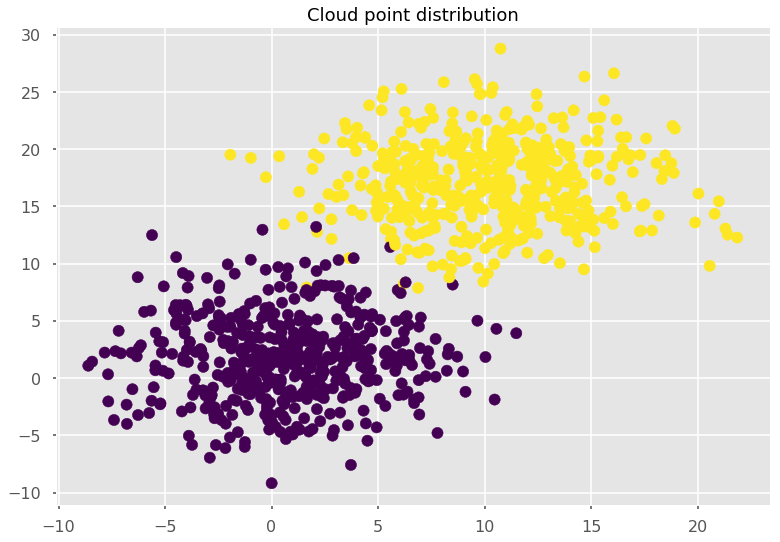

In [12]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')
plt.scatter(logistic_x[:,0], logistic_x[:,1], c=logistic_y)
plt.title('Cloud point distribution', fontsize=18)

One of the most important things that you need to know is that it really doesn't matter, which model you want to train and what data you will use for it. The interface always is the same. And now we are going to see it.

First of all, as in the previous time, Dataset is created and split. Only in the preloaded data and the size of the dataset is the difference. 

In [13]:
logistic_dset = Dataset(np.arange(size), batch_class=MyBatch)
logistic_dset.cv_split()

As you can see, the structure of pipeline is almost the same. In __inputs_config__ __shape__ has changed from 13 to 2 because now we have two coordinates of dots. In labels new parameters appeared:
* __classes__ - the number of classes. We have a binary classification, hence 2 classes. 
* __transform__ - transforms with answers. We use one hot encoding or 'ohe'.

In [14]:
inputs_config = {'input': {'shape': (2)},
                 'labels': {'classes': 2,
                            'transform': 'ohe',
                            'name': 'targets'}}

Create and instantly complete our pipeline by using the __run__ function

In [15]:
BATCH_SIZE=10
train_logistic = (logistic_dset.train.p
                .load((logistic_x, logistic_y))
                .init_variable('current_loss', init_on_each_run=list)
                .init_model('dynamic',
                            Regressions,
                            'logistic',
                            config={'inputs': inputs_config,
                                    'loss': 'ce',
                                    'optimizer': {'name':'Adam', 
                                                  'learning_rate':0.01},
                                    'input_block/inputs': 'input',
                                    'body/units': 2,
                                    'output': dict(ops=['labels', 'accuracy'])})
                .train_model('logistic',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                            save_to=V('current_loss'), mode='a', use_lock=True)
                .run(BATCH_SIZE, shuffle=True, n_epochs=10))

In the same way, create test pipeline and complete it too

In [16]:
BATCH_SIZE = 1
test_logistic = (logistic_dset.test.p
                .import_model('logistic', train_logistic)
                .load((logistic_x, logistic_y))
                .init_variable('probability', init_on_each_run=list)
                .predict_model('logistic', 
                             fetches='Regressions/accuracy' ,
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                             save_to=V('probability'), mode='a')
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

After rating the quality of training

In [17]:
prob = np.array(test_logistic.get_variable('probability')).reshape(-1)
percentage = np.mean(prob)
print('Percentage of true values: %.2f'%percentage)

Percentage of true values: 1.00


# Poisson regression is being used if the answer is count. 
The example shows how we can train poisson regression by using generated data from poisson distribution.

In [18]:
size = 1000
NUM_DIM = 13
poisson_x, poisson_y = generate_poisson_data(np.random.random(NUM_DIM), size)

Below you can see the same cell as previously, but with different names in models

In [19]:
poisson_dset = Dataset(np.arange(size), batch_class=MyBatch)
poisson_dset.cv_split()

We can create our own loss function and use it to train the model

In [20]:
def loss_poisson(target, predictions):
    return tf.reduce_mean(tf.nn.log_poisson_loss(target, predictions))

Again __shape__ equal 13, as the shape of data

In [21]:
inputs_config = {'input': {'shape': (13)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

Create and train the pipeline

In [22]:
BATCH_SIZE=100
train_poisson = (poisson_dset.train.p
                .load((poisson_x, poisson_y))
                .init_variable('shape')
                .init_model('dynamic', 
                            Regressions, 
                            'poisson',
                            config={'inputs': inputs_config,
                                    'loss': loss_poisson,
                                    'optimizer': {'name': 'Adam', 
                                                  'learning_rate': 0.02},
                                    'input_block/inputs': 'input',
                                    'body/units': 1,
                                    'output': dict(ops=['labels'])})
                .train_model('poisson',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')})
                .run(BATCH_SIZE, shuffle=True, n_epochs=150))

Create pipeline and make predictions

In [23]:
test_poisson = ((poisson_dset.test.p
                .load((poisson_x, poisson_y))
                .import_model('poisson', train_poisson)
                .init_variable('all_predictions', init_on_each_run=list)
                .init_variable('answers', init_on_each_run=list)
                .predict_model('poisson', 
                               fetches=['Regressions/predicted_poisson_answer', 'labels'],
                               feed_dict={'input': B('input_data'),
                                          'labels': B('labels')},
                               save_to=[V('all_predictions'), V('answers')], mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=1))

Rate the quality

In [24]:
pred = np.array(test_poisson.get_variable('all_predictions')).reshape(-1)
target = np.array(test_poisson.get_variable('answers')).reshape(-1)


true_var = np.mean((target - np.mean(target))**2)
predict_var = np.mean((pred - np.mean(pred))**2)

percent = np.mean(np.abs(pred - target))/np.mean(target)*100
print('Percentage of errors: {}%'.format(round(percent, 3)), 'Variance ratio: %.3f' % (predict_var / true_var))

Percentage of errors: 6.502% Variance ratio: 0.982


### Conclusions
* No matter what you want to train and what data you want to use for it, pipeline view always is the same.
* Now you know how using dataset:
    * Train linear regression with 13-dimensions data.
    * Train logistic regression with another type of data - two-dimensions clouds of dots.
    * Create your own loss function and train poisson regression.

### And now what?
After reading this notebook you may be wondering what to do next. I have ideas for you:
* Create own data generator with many(15 and more)-dimensions data.
* Get favourite type of regression and create answers (if your regression is logistic regression create more than 2 classes)
* Сomplicate the model in order to improve the quality.
* Train your model on created before data and tell us about your attainment:)


In next [notebook](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/II.CNN/II.CNN.ipynb), we will build our first convolution neural network!